* ##### Install necessary Python packages using pip
* ##### Use the 'pip' command to install packages
* ##### The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
* ##### We're installing the following packages:
* ##### - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
* ##### - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
* ##### - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks
* ##### - 'mlflow': MLflow is an open-source platform for managing the end-to-end machine learning lifecycle, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models
* ##### Note: Before running this code, make sure you have Python and pip installed on your system.
* ##### Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).

In [102]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

* #### Importing necessary libraries and modules
* #### Importing the necessary Metrics
* #### Import the necessary module from the Python Imaging Library (PIL).

In [103]:
import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings during execution
import random
import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)


from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

* ##### Load the 100 Classifications of Butterfly images
* ##### Extract the Image labels from the dataset
* ##### Create a pandas dataframe from the collected file names and labels 
* ##### Showing the head and tail of the Dataframe

In [104]:

image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []


# Iterate through all image files in the specified directory
for file in tqdm(sorted((Path('/kaggle/input/butterflies-100-image-dataset-classification/').glob('*/*/*.*')))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)
df

100%|██████████| 13639/13639 [00:00<00:00, 223301.75it/s]

13639 13639
(13639, 2)


,image,label
0,/kaggle/input/butterflies-100-image-dataset-cl...,ADONIS
1,/kaggle/input/butterflies-100-image-dataset-cl...,ADONIS
2,/kaggle/input/butterflies-100-image-dataset-cl...,ADONIS
3,/kaggle/input/butterflies-100-image-dataset-cl...,ADONIS
4,/kaggle/input/butterflies-100-image-dataset-cl...,ADONIS
...,...,...
13634,/kaggle/input/butterflies-100-image-dataset-cl...,ZEBRA LONG WING
13635,/kaggle/input/butterflies-100-image-dataset-cl...,ZEBRA LONG WING
13636,/kaggle/input/butterflies-100-image-dataset-cl...,ZEBRA LONG WING
13637,/kaggle/input/butterflies-100-image-dataset-cl...,ZEBRA LONG WING


* ### The Unique Classes if the Butterflies

In [105]:
df['label'].unique()

array(['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88',
       'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH',
       'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH',
       'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK',
       'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING',
       'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE',
       'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER',
       'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA',
       'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH',
       'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT',
       'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA',
       'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT',
       'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH',
       'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY',
       'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK'

### Counting total butterflies of each class

In [106]:
label_counts = df['label'].value_counts()
print("Label Counts:\n", label_counts)

Label Counts:
 label
MOURNING CLOAK         197
GREEN HAIRSTREAK       186
BROWN ARGUS            179
BROOKES BIRDWING       175
SLEEPY ORANGE          163
                      ... 
GOLD BANDED            114
CRIMSON PATCH          113
MALACHITE              113
WOOD SATYR             112
SIXSPOT BURNET MOTH    111
Name: count, Length: 100, dtype: int64


In [107]:
description = df.describe()
print("Description of numeric columns:\n", description)

Description of numeric columns:
                                                     image           label
count                                               13639           13639
unique                                              13639             100
top     /kaggle/input/butterflies-100-image-dataset-cl...  MOURNING CLOAK
freq                                                    1             197


In [108]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(19700, 2)


In [109]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())
len(dataset)

19700

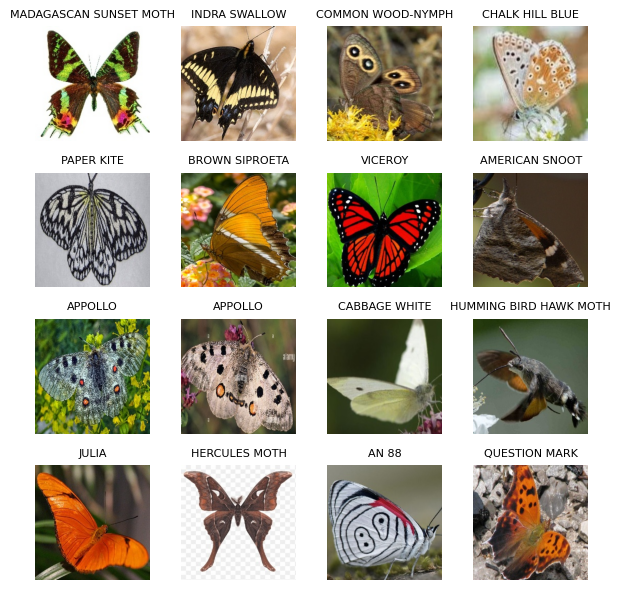

In [110]:
# Number of images to display
num_images = 16

# Set up the subplot grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6)) 
axes = axes.flatten()

for ax in axes:
    imgIndex = random.randint(0,len(dataset))
    img = dataset[imgIndex]["image"]
    label = dataset[imgIndex]["label"]
     # Display image
    ax.imshow(img)
    
    # Display label
    ax.set_title(label, fontsize=8)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [111]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(labels)))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

label2id, id2label

({'ADONIS': 0,
  'AFRICAN GIANT SWALLOWTAIL': 1,
  'AMERICAN SNOOT': 2,
  'AN 88': 3,
  'APPOLLO': 4,
  'ARCIGERA FLOWER MOTH': 5,
  'ATALA': 6,
  'ATLAS MOTH': 7,
  'BANDED ORANGE HELICONIAN': 8,
  'BANDED PEACOCK': 9,
  'BANDED TIGER MOTH': 10,
  'BECKERS WHITE': 11,
  'BIRD CHERRY ERMINE MOTH': 12,
  'BLACK HAIRSTREAK': 13,
  'BLUE MORPHO': 14,
  'BLUE SPOTTED CROW': 15,
  'BROOKES BIRDWING': 16,
  'BROWN ARGUS': 17,
  'BROWN SIPROETA': 18,
  'CABBAGE WHITE': 19,
  'CAIRNS BIRDWING': 20,
  'CHALK HILL BLUE': 21,
  'CHECQUERED SKIPPER': 22,
  'CHESTNUT': 23,
  'CINNABAR MOTH': 24,
  'CLEARWING MOTH': 25,
  'CLEOPATRA': 26,
  'CLODIUS PARNASSIAN': 27,
  'CLOUDED SULPHUR': 28,
  'COMET MOTH': 29,
  'COMMON BANDED AWL': 30,
  'COMMON WOOD-NYMPH': 31,
  'COPPER TAIL': 32,
  'CRECENT': 33,
  'CRIMSON PATCH': 34,
  'DANAID EGGFLY': 35,
  'EASTERN COMA': 36,
  'EASTERN DAPPLE WHITE': 37,
  'EASTERN PINE ELFIN': 38,
  'ELBOWED PIERROT': 39,
  'EMPEROR GUM MOTH': 40,
  'GARDEN TIGER MOTH': 41

In [112]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 75-25 split ratio.
dataset = dataset.train_test_split(test_size=0.25, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/19700 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/19700 [00:00<?, ? examples/s]

**Some Random Images From Train Data**

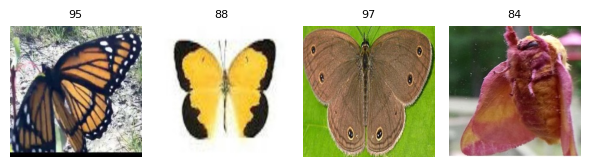

In [113]:

# Number of images to display
num_images = 4

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6)) 
axes = axes.flatten()

for ax in axes:
    imgIndex = random.randint(0,len(train_data))
    img = train_data[imgIndex]["image"]
    label = train_data[imgIndex]["label"]
     # Display image
    ax.imshow(img)
    
    # Display label
    ax.set_title(label, fontsize=8)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


**Some Random Images From Test Data**

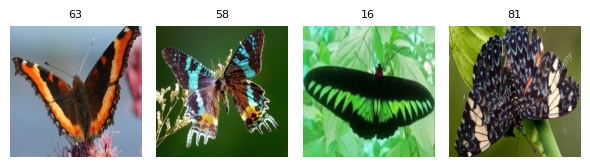

In [114]:

# Number of images to display
num_images = 4

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6)) 
axes = axes.flatten()

for ax in axes:
    imgIndex = random.randint(0,len(test_data))
    img = train_data[imgIndex]["image"]
    label = train_data[imgIndex]["label"]
     # Display image
    ax.imshow(img)
    
    # Display label
    ax.set_title(label, fontsize=8)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [115]:
# Define the pre-trained ViT model string
model_str = "dima806/100_butterfly_types_image_detection" #'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(45),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


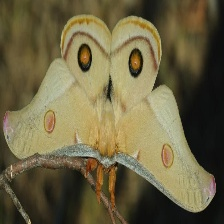

In [116]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

print(train_data[0]['pixel_values'])
train_data[0]["image"]

In [117]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [118]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)


85.875556


In [119]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [120]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "100_butterfly_types_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 3

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=3e-6,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=64,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=32,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none"  # log to none
)

In [121]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [122]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 1.5188697576522827,
 'eval_accuracy': 0.9569543147208122,
 'eval_runtime': 46.8163,
 'eval_samples_per_second': 105.198,
 'eval_steps_per_second': 3.289}

In [123]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.467999,0.957360
2,No log,1.431725,0.957563
3,1.427600,1.419485,0.958173


TrainOutput(global_step=693, training_loss=1.4142670954804744, metrics={'train_runtime': 1074.5903, 'train_samples_per_second': 41.248, 'train_steps_per_second': 0.645, 'total_flos': 3.4378494007044096e+18, 'train_loss': 1.4142670954804744, 'epoch': 3.0})

In [124]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()


{'eval_loss': 1.419485092163086,
 'eval_accuracy': 0.9581725888324873,
 'eval_runtime': 40.4151,
 'eval_samples_per_second': 121.86,
 'eval_steps_per_second': 3.81,
 'epoch': 3.0}

Accuracy: 0.9593908629441624
Precision: 0.9616501556354806
F1 Score: 0.9590483320741666


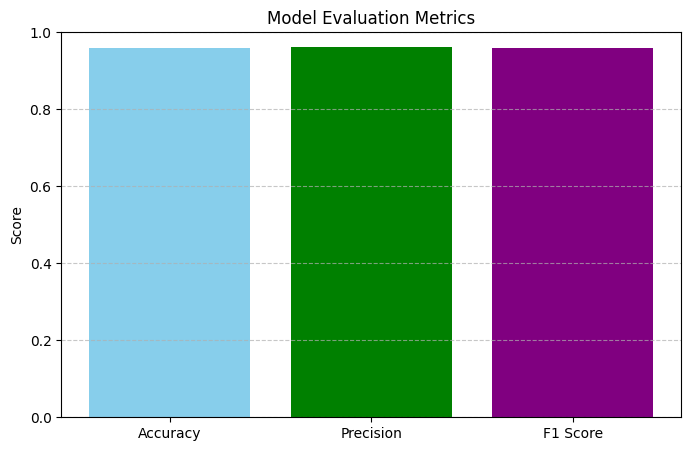

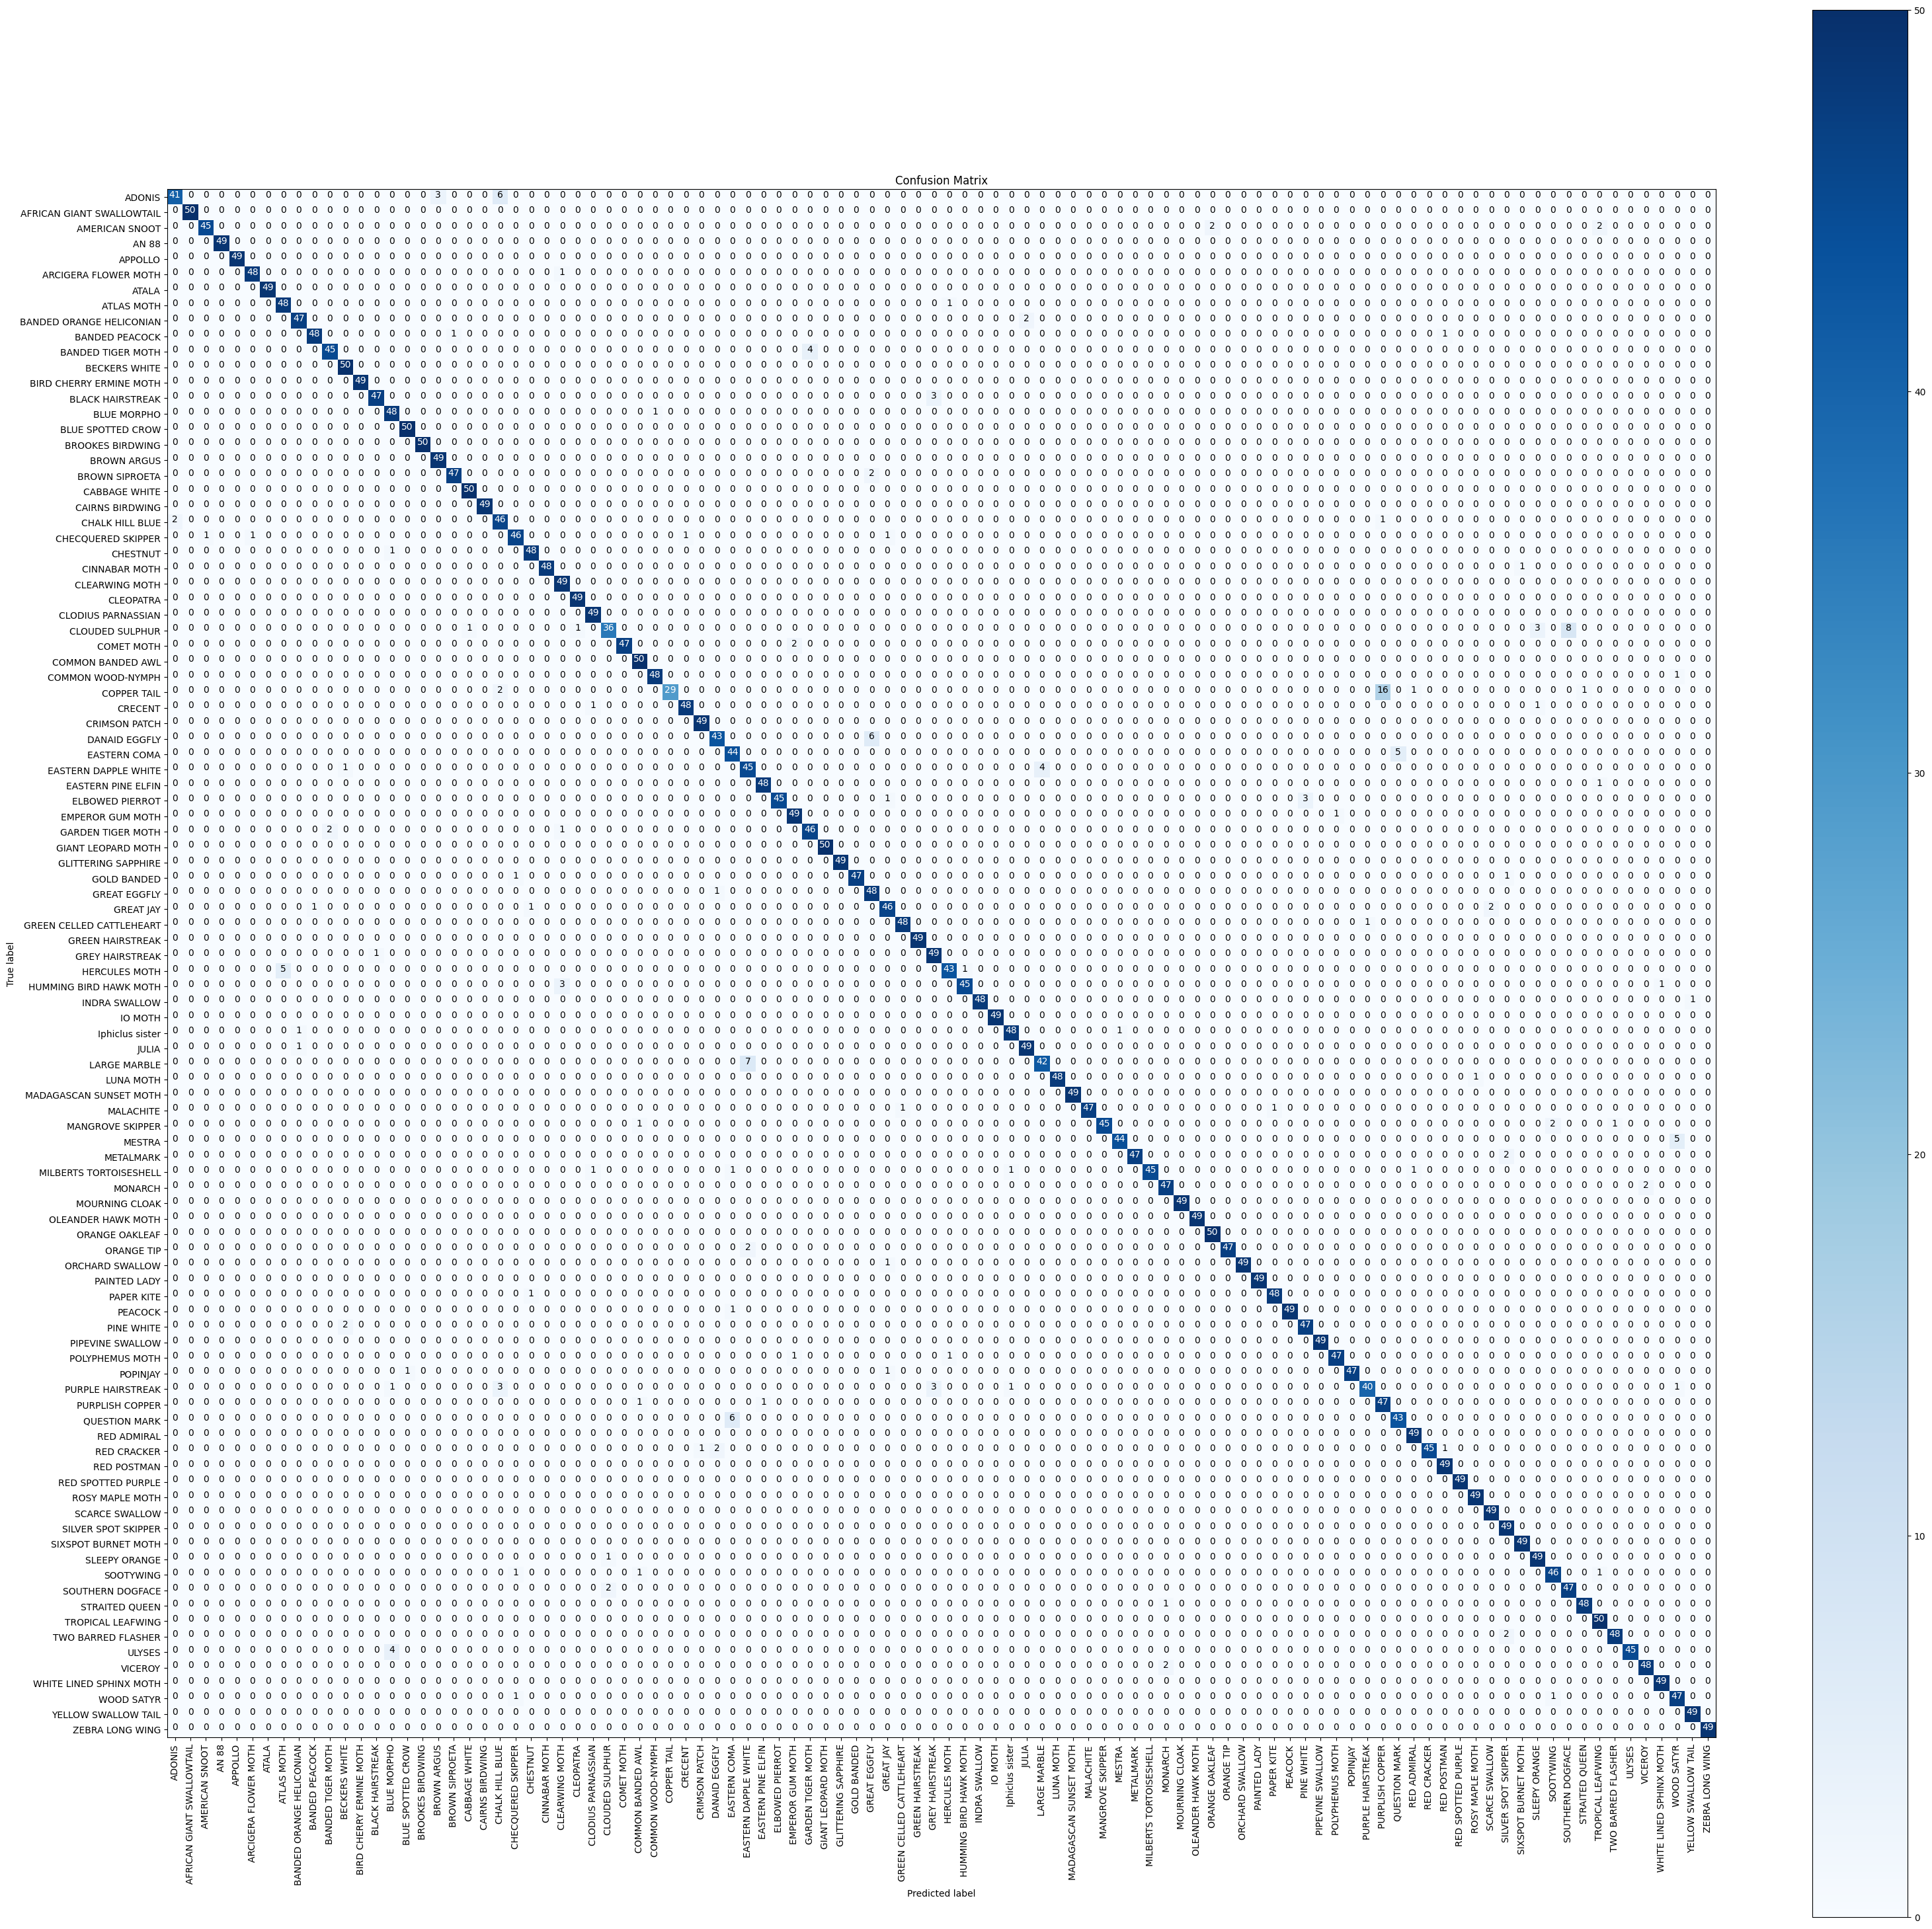

In [125]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, f1_score

# Assuming y_true and y_pred are your true labels and predicted labels respectively
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)

# Sample data
metrics = ['Accuracy', 'Precision', 'F1 Score']
scores = [accuracy, precision, f1]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['skyblue', 'green', 'purple'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.show()



# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(32, 30))
    


In [126]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

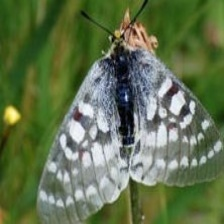

In [127]:
# Accessing an image from the 'test_data' dataset using index .

import random

# Assuming test_data is your dataset containing images
index = random.randint(0, len(test_data) - 1)
image = test_data[index]["image"]

# Displaying the image variable
image


In [128]:
# Apply the 'pipe' function to process the 'image' variable.
predictions = pipe(image)
for i in predictions:
    print(i)
    
highest_score_entry = max(predictions, key=lambda x: x['score'])

# Print the label of the entry with the highest score

print('\n\nSo the predicted Class is: ',highest_score_entry['label'])
print('\nActual Class:', id2label[test_data[index]["label"]])

{'label': 'CLODIUS PARNASSIAN', 'score': 0.21949055790901184}
{'label': 'APPOLLO', 'score': 0.024165280163288116}
{'label': 'PINE WHITE', 'score': 0.022087445482611656}
{'label': 'BECKERS WHITE', 'score': 0.013917685486376286}
{'label': 'GLITTERING SAPPHIRE', 'score': 0.013882641680538654}


So the predicted Class is:  CLODIUS PARNASSIAN

Actual Class: CLODIUS PARNASSIAN
